# Лабораторная работа №2. Реализация глубокой нейронной сети

**Данные:** В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

**Данные можно скачать по ссылке:**
- https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);
- https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
- http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import pathlib

train_data_dir = pathlib.Path('./Datasets/1-3/notMNIST_large')

train_image_count = len(list(train_data_dir.glob('*/*.png')))
train_image_count

529113

In [3]:
test_data_dir = pathlib.Path('./Datasets/1-3/notMNIST_small')
test_image_count = len(list(test_data_dir.glob('*/*.png')))
test_image_count

18724

In [4]:
BATCH_SIZE = 1000
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['H', 'F', 'E', 'I', 'D', 'B', 'A', 'J', 'C', 'G'], dtype='<U1')

In [5]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.02)
train_data_gen = train_image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 529113 images belonging to 10 classes.


In [6]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = train_image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 18724 images belonging to 10 classes.


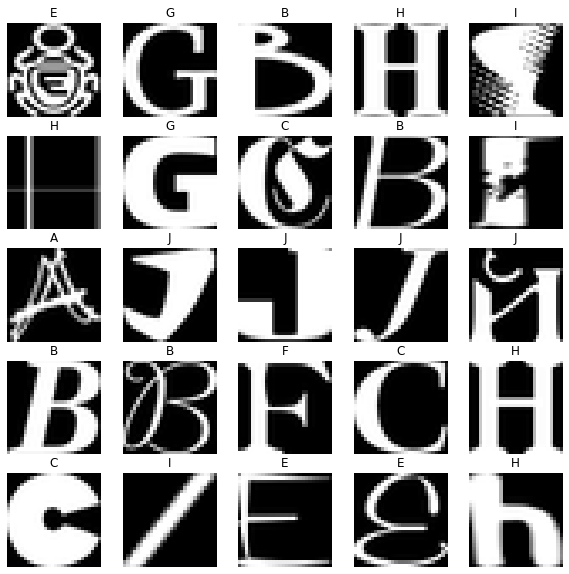

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n][:, :, 0], cmap='gray')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

### Задание 1. Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).

In [26]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    ACTIVATION_FUNCTIONS = (
        'linear',
        'sigmoid', 
        'tanh',
        'relu',
    )
    
    def __init__(self, layers_count, nodes=None, optimizer=None, use_regularizatrion_and_dropuot=False):
        self.use_regularizatrion_and_dropuot = use_regularizatrion_and_dropuot
        self.layers_count = layers_count
        self.inital_nodes = nodes or []
        self._nodes_count = nodes or []
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
    
    def _get_layer_nodes_count(self, index):
        if self.inital_nodes:
            return self.inital_nodes[index]

        nodes_count = random.randrange(100, 400)
        self._nodes_count.append(nodes_count)
        return nodes_count
    
    def _generate_layer(self, index):
        nodes_count = self._get_layer_nodes_count(index)
        activation_fun = self.ACTIVATION_FUNCTIONS[index]

        layer = tf.keras.layers.Dense(nodes_count, activation=activation_fun)
        layer._name = f'dense_{index}_{activation_fun}'

        return layer
   
    def _generate_layer_with_regularization(self, index):
        nodes_count = self._get_layer_nodes_count(index)
        activation_fun = self.ACTIVATION_FUNCTIONS[index]
        regularizer = tf.keras.regularizers.l2(0.01)

        layer = tf.keras.layers.Dense(nodes_count, activation=activation_fun, activity_regularizer=regularizer)
        layer._name = f'dense_{index}_{activation_fun}'

        return layer, nodes_count
    
    def _generate_layer_with_regularizatrion_and_dropuot(self, index):
        layer, nodes_count = self._generate_layer_with_regularization(index)
        dropout_rate = np.round(nodes_count / 10000, 2) if nodes_count > 200 else 0
        dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        return [layer, dropout_layer]
    
    def _get_hidden_layers(self):
        if not self.use_regularizatrion_and_dropuot:
            return [self._generate_layer(i) for i in range(self.layers_count)]

        hidden_layers = np.array([
            self._generate_layer_with_regularizatrion_and_dropuot(i)
            for i in range(self.layers_count)
        ])
        return hidden_layers.flatten()

    def initialize(self):
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        hidden_layers = self._get_hidden_layers()

        self.model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
          *hidden_layers,
          tf.keras.layers.Dense(10, activation='softmax')
        ])

        self.model.compile(optimizer=self.optimizer, loss=loss_fn, metrics=['accuracy'])

    def fit(self, x_train, y_train=None, **kwargs):
        return self.model.fit(
            x_train,  y_train, epochs=self.EPOCH_COUNT, workers=6, validation_split=0.05, **kwargs)

    def fit_generator(self, generator, batch_count):
        now = datetime.datetime.now()
        tran_accuracy = 0
        val_accuracy = 0

        for i in range(batch_count):
            print(f'Start training batch #{i}')
            x, y = next(generator)
            batch_history = self.fit(x, y)
            tran_accuracy += batch_history.history['accuracy'][-1]
            val_accuracy += batch_history.history['val_accuracy'][-1]
        
        average_train_error = tran_accuracy / batch_count
        average_validation_error = val_accuracy / batch_count

        print('\nSpent time:', datetime.datetime.now() - now)
        print('Average train error:', average_train_error)
        print('Average validation error:', average_validation_error)

        return [average_train_error, average_validation_error]

    def test(self, x_test, y_test=None):
        return self.model.evaluate(x_test,  y_test, verbose=1)
    
    def summary(self):
        return self.model.summary()

In [16]:
model = Model(4)
model.initialize()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 112)               87920     
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 215)               24295     
_________________________________________________________________
dense_2_tanh (Dense)         (None, 225)               48600     
_________________________________________________________________
dense_3_relu (Dense)         (None, 348)               78648     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                3490      
Total params: 242,953
Trainable params: 242,953
Non-trainable params: 0
________________________________________________

### Задание 2. Как улучшилась точность классификатора по сравнению с логистической регрессией?


In [17]:
COUNT_OF_BUTCHES = 210

In [18]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 324us/sample - loss: 2.3005 - accuracy: 0.1326 - val_loss: 2.2925 - val_accuracy: 0.2200
Epoch 2/10
950/950 [==============================] - 0s 64us/sample - loss: 2.2930 - accuracy: 0.2084 - val_loss: 2.2839 - val_accuracy: 0.2000
Epoch 3/10
950/950 [==============================] - 0s 65us/sample - loss: 2.2824 - accuracy: 0.2189 - val_loss: 2.2650 - val_accuracy: 0.2800
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 2.2594 - accuracy: 0.2368 - val_loss: 2.2234 - val_accuracy: 0.2800
Epoch 5/10
950/950 [==============================] - 0s 71us/sample - loss: 2.2165 - accuracy: 0.2684 - val_loss: 2.1777 - val_accuracy: 0.3000
Epoch 6/10
950/950 [==============================] - 0s 71us/sample - loss: 2.1798 - accuracy: 0.2737 - val_loss: 2.1512 - val_accuracy: 0.3000
Epoch 7/10
950/950 [==============================] - 0s 66u

950/950 [==============================] - 0s 69us/sample - loss: 1.6004 - accuracy: 0.8684 - val_loss: 1.6659 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 68us/sample - loss: 1.6000 - accuracy: 0.8642 - val_loss: 1.6536 - val_accuracy: 0.8000
Epoch 10/10
950/950 [==============================] - 0s 62us/sample - loss: 1.5939 - accuracy: 0.8716 - val_loss: 1.6446 - val_accuracy: 0.8000
Start training batch #11
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 67us/sample - loss: 1.6410 - accuracy: 0.8200 - val_loss: 1.6447 - val_accuracy: 0.8200
Epoch 2/10
950/950 [==============================] - 0s 61us/sample - loss: 1.6300 - accuracy: 0.8347 - val_loss: 1.6108 - val_accuracy: 0.8400
Epoch 3/10
950/950 [==============================] - 0s 61us/sample - loss: 1.6242 - accuracy: 0.8411 - val_loss: 1.6058 - val_accuracy: 0.8600
Epoch 4/10
950/950 [==============================] - 0s 68us/sample -

950/950 [==============================] - 0s 82us/sample - loss: 1.5890 - accuracy: 0.8726 - val_loss: 1.5942 - val_accuracy: 0.8600
Epoch 6/10
950/950 [==============================] - 0s 84us/sample - loss: 1.5867 - accuracy: 0.8779 - val_loss: 1.5828 - val_accuracy: 0.8800
Epoch 7/10
950/950 [==============================] - 0s 83us/sample - loss: 1.5805 - accuracy: 0.8832 - val_loss: 1.5861 - val_accuracy: 0.8600
Epoch 8/10
950/950 [==============================] - 0s 82us/sample - loss: 1.5798 - accuracy: 0.8832 - val_loss: 1.5795 - val_accuracy: 0.8800
Epoch 9/10
950/950 [==============================] - 0s 82us/sample - loss: 1.5762 - accuracy: 0.8863 - val_loss: 1.5861 - val_accuracy: 0.8800
Epoch 10/10
950/950 [==============================] - 0s 83us/sample - loss: 1.5726 - accuracy: 0.8895 - val_loss: 1.5876 - val_accuracy: 0.8600
Start training batch #22
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 61us/sample -

950/950 [==============================] - 0s 60us/sample - loss: 1.6373 - accuracy: 0.8200 - val_loss: 1.7227 - val_accuracy: 0.7400
Epoch 3/10
950/950 [==============================] - 0s 70us/sample - loss: 1.6318 - accuracy: 0.8253 - val_loss: 1.7018 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 71us/sample - loss: 1.6258 - accuracy: 0.8347 - val_loss: 1.7268 - val_accuracy: 0.7400
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.6221 - accuracy: 0.8400 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 6/10
950/950 [==============================] - 0s 72us/sample - loss: 1.6174 - accuracy: 0.8442 - val_loss: 1.7023 - val_accuracy: 0.7600
Epoch 7/10
950/950 [==============================] - 0s 72us/sample - loss: 1.6132 - accuracy: 0.8474 - val_loss: 1.7077 - val_accuracy: 0.7600
Epoch 8/10
950/950 [==============================] - 0s 71us/sample - loss: 1.6109 - accuracy: 0.8505 - val_loss: 1.7138 - val_accuracy: 0.7

950/950 [==============================] - 0s 74us/sample - loss: 1.5994 - accuracy: 0.8611 - val_loss: 1.6398 - val_accuracy: 0.8200
Start training batch #43
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 63us/sample - loss: 1.6198 - accuracy: 0.8421 - val_loss: 1.6300 - val_accuracy: 0.8400
Epoch 2/10
950/950 [==============================] - 0s 70us/sample - loss: 1.6141 - accuracy: 0.8474 - val_loss: 1.6254 - val_accuracy: 0.8400
Epoch 3/10
950/950 [==============================] - 0s 72us/sample - loss: 1.6061 - accuracy: 0.8547 - val_loss: 1.6252 - val_accuracy: 0.8200
Epoch 4/10
950/950 [==============================] - 0s 72us/sample - loss: 1.5977 - accuracy: 0.8632 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 5/10
950/950 [==============================] - 0s 71us/sample - loss: 1.5907 - accuracy: 0.8726 - val_loss: 1.6218 - val_accuracy: 0.8400
Epoch 6/10
950/950 [==============================] - 0s 70us/sample - 

950/950 [==============================] - 0s 70us/sample - loss: 1.5886 - accuracy: 0.8747 - val_loss: 1.5869 - val_accuracy: 0.8800
Epoch 8/10
950/950 [==============================] - 0s 63us/sample - loss: 1.5855 - accuracy: 0.8758 - val_loss: 1.5801 - val_accuracy: 0.8800
Epoch 9/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5835 - accuracy: 0.8779 - val_loss: 1.5933 - val_accuracy: 0.8600
Epoch 10/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5803 - accuracy: 0.8821 - val_loss: 1.5848 - val_accuracy: 0.8800
Start training batch #54
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 63us/sample - loss: 1.6311 - accuracy: 0.8284 - val_loss: 1.6169 - val_accuracy: 0.8400
Epoch 2/10
950/950 [==============================] - 0s 64us/sample - loss: 1.6208 - accuracy: 0.8400 - val_loss: 1.6185 - val_accuracy: 0.8600
Epoch 3/10
950/950 [==============================] - 0s 57us/sample -

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 65us/sample - loss: 1.6229 - accuracy: 0.8358 - val_loss: 1.6880 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 66us/sample - loss: 1.6119 - accuracy: 0.8516 - val_loss: 1.6748 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 65us/sample - loss: 1.6063 - accuracy: 0.8547 - val_loss: 1.6858 - val_accuracy: 0.7800
Epoch 4/10
950/950 [==============================] - 0s 65us/sample - loss: 1.6002 - accuracy: 0.8600 - val_loss: 1.6766 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5953 - accuracy: 0.8663 - val_loss: 1.6686 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 73us/sample - loss: 1.5908 - accuracy: 0.8695 - val_loss: 1.6824 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 63us/sample - loss: 1.5894 -

Epoch 5/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5994 - accuracy: 0.8632 - val_loss: 1.5450 - val_accuracy: 0.9200
Epoch 6/10
950/950 [==============================] - 0s 70us/sample - loss: 1.5960 - accuracy: 0.8653 - val_loss: 1.5414 - val_accuracy: 0.9200
Epoch 7/10
950/950 [==============================] - 0s 65us/sample - loss: 1.5943 - accuracy: 0.8684 - val_loss: 1.5407 - val_accuracy: 0.9200
Epoch 8/10
950/950 [==============================] - 0s 64us/sample - loss: 1.5949 - accuracy: 0.8653 - val_loss: 1.5403 - val_accuracy: 0.9200
Epoch 9/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5905 - accuracy: 0.8705 - val_loss: 1.5414 - val_accuracy: 0.9200
Epoch 10/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5899 - accuracy: 0.8705 - val_loss: 1.5412 - val_accuracy: 0.9200
Start training batch #65
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 63

950/950 [==============================] - 0s 76us/sample - loss: 1.5811 - accuracy: 0.8789 - val_loss: 1.6771 - val_accuracy: 0.7800
Epoch 10/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5787 - accuracy: 0.8821 - val_loss: 1.6917 - val_accuracy: 0.7600
Start training batch #70
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 65us/sample - loss: 1.6045 - accuracy: 0.8547 - val_loss: 1.6001 - val_accuracy: 0.8600
Epoch 2/10
950/950 [==============================] - 0s 71us/sample - loss: 1.5942 - accuracy: 0.8684 - val_loss: 1.5892 - val_accuracy: 0.8800
Epoch 3/10
950/950 [==============================] - 0s 68us/sample - loss: 1.5868 - accuracy: 0.8758 - val_loss: 1.5870 - val_accuracy: 0.8800
Epoch 4/10
950/950 [==============================] - 0s 65us/sample - loss: 1.5822 - accuracy: 0.8800 - val_loss: 1.5881 - val_accuracy: 0.8600
Epoch 5/10
950/950 [==============================] - 0s 64us/sample -

950/950 [==============================] - 0s 69us/sample - loss: 1.5931 - accuracy: 0.8695 - val_loss: 1.6126 - val_accuracy: 0.8400
Epoch 7/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5909 - accuracy: 0.8716 - val_loss: 1.5876 - val_accuracy: 0.8800
Epoch 8/10
950/950 [==============================] - 0s 68us/sample - loss: 1.5882 - accuracy: 0.8747 - val_loss: 1.6026 - val_accuracy: 0.8600
Epoch 9/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5874 - accuracy: 0.8737 - val_loss: 1.6068 - val_accuracy: 0.8400
Epoch 10/10
950/950 [==============================] - 0s 68us/sample - loss: 1.5840 - accuracy: 0.8768 - val_loss: 1.6088 - val_accuracy: 0.8400
Start training batch #81
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 140us/sample - loss: 1.6169 - accuracy: 0.8432 - val_loss: 1.5821 - val_accuracy: 0.8800
Epoch 2/10
950/950 [==============================] - 0s 185us/sample

950/950 [==============================] - 0s 80us/sample - loss: 1.5987 - accuracy: 0.8632 - val_loss: 1.6166 - val_accuracy: 0.8400
Epoch 4/10
950/950 [==============================] - 0s 82us/sample - loss: 1.5970 - accuracy: 0.8642 - val_loss: 1.6058 - val_accuracy: 0.8600
Epoch 5/10
950/950 [==============================] - 0s 83us/sample - loss: 1.5876 - accuracy: 0.8737 - val_loss: 1.6111 - val_accuracy: 0.8600
Epoch 6/10
950/950 [==============================] - 0s 86us/sample - loss: 1.5852 - accuracy: 0.8768 - val_loss: 1.6073 - val_accuracy: 0.8600
Epoch 7/10
950/950 [==============================] - 0s 73us/sample - loss: 1.5829 - accuracy: 0.8789 - val_loss: 1.6051 - val_accuracy: 0.8600
Epoch 8/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5817 - accuracy: 0.8800 - val_loss: 1.6036 - val_accuracy: 0.8600
Epoch 9/10
950/950 [==============================] - 0s 68us/sample - loss: 1.5811 - accuracy: 0.8789 - val_loss: 1.6064 - val_accuracy: 0.8

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 61us/sample - loss: 1.6167 - accuracy: 0.8421 - val_loss: 1.5861 - val_accuracy: 0.8800
Epoch 2/10
950/950 [==============================] - 0s 63us/sample - loss: 1.6019 - accuracy: 0.8589 - val_loss: 1.5863 - val_accuracy: 0.8800
Epoch 3/10
950/950 [==============================] - 0s 56us/sample - loss: 1.5973 - accuracy: 0.8642 - val_loss: 1.5934 - val_accuracy: 0.8600
Epoch 4/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5961 - accuracy: 0.8632 - val_loss: 1.5843 - val_accuracy: 0.8800
Epoch 5/10
950/950 [==============================] - 0s 56us/sample - loss: 1.5874 - accuracy: 0.8737 - val_loss: 1.5808 - val_accuracy: 0.8800
Epoch 6/10
950/950 [==============================] - 0s 59us/sample - loss: 1.5834 - accuracy: 0.8779 - val_loss: 1.5840 - val_accuracy: 0.8800
Epoch 7/10
950/950 [==============================] - 0s 58us/sample - loss: 1.5815 -

Epoch 5/10
950/950 [==============================] - 0s 61us/sample - loss: 1.5974 - accuracy: 0.8642 - val_loss: 1.5626 - val_accuracy: 0.9000
Epoch 6/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5947 - accuracy: 0.8653 - val_loss: 1.5628 - val_accuracy: 0.9000
Epoch 7/10
950/950 [==============================] - 0s 58us/sample - loss: 1.5945 - accuracy: 0.8663 - val_loss: 1.5669 - val_accuracy: 0.9000
Epoch 8/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5896 - accuracy: 0.8705 - val_loss: 1.5648 - val_accuracy: 0.9000
Epoch 9/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5895 - accuracy: 0.8716 - val_loss: 1.5616 - val_accuracy: 0.9000
Epoch 10/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5878 - accuracy: 0.8737 - val_loss: 1.5630 - val_accuracy: 0.9000
Start training batch #108
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 6

950/950 [==============================] - 0s 60us/sample - loss: 1.5773 - accuracy: 0.8832 - val_loss: 1.6326 - val_accuracy: 0.8200
Epoch 10/10
950/950 [==============================] - 0s 70us/sample - loss: 1.5772 - accuracy: 0.8832 - val_loss: 1.6322 - val_accuracy: 0.8200
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 62us/sample - loss: 1.6109 - accuracy: 0.8505 - val_loss: 1.5798 - val_accuracy: 0.8800
Epoch 2/10
950/950 [==============================] - 0s 73us/sample - loss: 1.6015 - accuracy: 0.8600 - val_loss: 1.5819 - val_accuracy: 0.8800
Epoch 3/10
950/950 [==============================] - 0s 72us/sample - loss: 1.5954 - accuracy: 0.8674 - val_loss: 1.5802 - val_accuracy: 0.8800
Epoch 4/10
950/950 [==============================] - 0s 71us/sample - loss: 1.5886 - accuracy: 0.8726 - val_loss: 1.5806 - val_accuracy: 0.8800
Epoch 5/10
950/950 [==============================] - 0s 72us/sample 

950/950 [==============================] - 0s 60us/sample - loss: 1.5910 - accuracy: 0.8684 - val_loss: 1.7385 - val_accuracy: 0.7400
Epoch 7/10
950/950 [==============================] - 0s 67us/sample - loss: 1.5867 - accuracy: 0.8747 - val_loss: 1.7375 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 71us/sample - loss: 1.5861 - accuracy: 0.8747 - val_loss: 1.7354 - val_accuracy: 0.7200
Epoch 9/10
950/950 [==============================] - 0s 69us/sample - loss: 1.5858 - accuracy: 0.8747 - val_loss: 1.7349 - val_accuracy: 0.7200
Epoch 10/10
950/950 [==============================] - 0s 63us/sample - loss: 1.5856 - accuracy: 0.8758 - val_loss: 1.7384 - val_accuracy: 0.7400
Start training batch #124
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 70us/sample - loss: 1.6173 - accuracy: 0.8432 - val_loss: 1.6577 - val_accuracy: 0.8000
Epoch 2/10
950/950 [==============================] - 0s 101us/sample

950/950 [==============================] - 0s 64us/sample - loss: 1.5960 - accuracy: 0.8663 - val_loss: 1.6597 - val_accuracy: 0.8000
Epoch 4/10
950/950 [==============================] - 0s 65us/sample - loss: 1.5902 - accuracy: 0.8705 - val_loss: 1.6604 - val_accuracy: 0.8000
Epoch 5/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5837 - accuracy: 0.8768 - val_loss: 1.6575 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 66us/sample - loss: 1.5810 - accuracy: 0.8800 - val_loss: 1.6547 - val_accuracy: 0.8000
Epoch 7/10
950/950 [==============================] - 0s 83us/sample - loss: 1.5775 - accuracy: 0.8842 - val_loss: 1.6589 - val_accuracy: 0.8000
Epoch 8/10
950/950 [==============================] - 0s 73us/sample - loss: 1.5765 - accuracy: 0.8842 - val_loss: 1.6587 - val_accuracy: 0.8000
Epoch 9/10
950/950 [==============================] - 0s 74us/sample - loss: 1.5761 - accuracy: 0.8842 - val_loss: 1.6587 - val_accuracy: 0.8

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 68us/sample - loss: 1.6110 - accuracy: 0.8495 - val_loss: 1.6138 - val_accuracy: 0.8400
Epoch 2/10
950/950 [==============================] - 0s 61us/sample - loss: 1.6037 - accuracy: 0.8568 - val_loss: 1.5904 - val_accuracy: 0.8800
Epoch 3/10
950/950 [==============================] - 0s 62us/sample - loss: 1.5970 - accuracy: 0.8642 - val_loss: 1.5729 - val_accuracy: 0.8800
Epoch 4/10
950/950 [==============================] - 0s 62us/sample - loss: 1.5908 - accuracy: 0.8716 - val_loss: 1.5654 - val_accuracy: 0.9000
Epoch 5/10
950/950 [==============================] - 0s 61us/sample - loss: 1.5868 - accuracy: 0.8747 - val_loss: 1.5738 - val_accuracy: 0.9000
Epoch 6/10
950/950 [==============================] - 0s 65us/sample - loss: 1.5793 - accuracy: 0.8832 - val_loss: 1.5662 - val_accuracy: 0.9000
Epoch 7/10
950/950 [==============================] - 0s 62us/sample - loss: 1.5759 -

Epoch 5/10
950/950 [==============================] - 0s 76us/sample - loss: 1.5903 - accuracy: 0.8726 - val_loss: 1.6179 - val_accuracy: 0.8400
Epoch 6/10
950/950 [==============================] - 0s 58us/sample - loss: 1.5870 - accuracy: 0.8747 - val_loss: 1.6210 - val_accuracy: 0.8400
Epoch 7/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5840 - accuracy: 0.8768 - val_loss: 1.6178 - val_accuracy: 0.8400
Epoch 8/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5835 - accuracy: 0.8779 - val_loss: 1.6179 - val_accuracy: 0.8400
Epoch 9/10
950/950 [==============================] - 0s 58us/sample - loss: 1.5811 - accuracy: 0.8800 - val_loss: 1.6201 - val_accuracy: 0.8400
Epoch 10/10
950/950 [==============================] - 0s 59us/sample - loss: 1.5813 - accuracy: 0.8789 - val_loss: 1.6175 - val_accuracy: 0.8400
Start training batch #151
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 7

950/950 [==============================] - 0s 59us/sample - loss: 1.5788 - accuracy: 0.8821 - val_loss: 1.5614 - val_accuracy: 0.9000
Epoch 10/10
950/950 [==============================] - 0s 60us/sample - loss: 1.5783 - accuracy: 0.8821 - val_loss: 1.5613 - val_accuracy: 0.9000
Start training batch #156
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 61us/sample - loss: 1.5912 - accuracy: 0.8684 - val_loss: 1.7583 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 56us/sample - loss: 1.5790 - accuracy: 0.8821 - val_loss: 1.7642 - val_accuracy: 0.7000
Epoch 3/10
950/950 [==============================] - 0s 56us/sample - loss: 1.5727 - accuracy: 0.8905 - val_loss: 1.7705 - val_accuracy: 0.6800
Epoch 4/10
950/950 [==============================] - 0s 57us/sample - loss: 1.5677 - accuracy: 0.8937 - val_loss: 1.7723 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 58us/sample 

950/950 [==============================] - 0s 77us/sample - loss: 1.5658 - accuracy: 0.8947 - val_loss: 1.6407 - val_accuracy: 0.8200
Epoch 7/10
950/950 [==============================] - 0s 75us/sample - loss: 1.5621 - accuracy: 0.8989 - val_loss: 1.6402 - val_accuracy: 0.8200
Epoch 8/10
950/950 [==============================] - 0s 73us/sample - loss: 1.5611 - accuracy: 0.8989 - val_loss: 1.6409 - val_accuracy: 0.8200
Epoch 9/10
950/950 [==============================] - 0s 73us/sample - loss: 1.5599 - accuracy: 0.9000 - val_loss: 1.6407 - val_accuracy: 0.8200
Epoch 10/10
950/950 [==============================] - 0s 74us/sample - loss: 1.5579 - accuracy: 0.9032 - val_loss: 1.6409 - val_accuracy: 0.8200
Start training batch #167
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 70us/sample - loss: 1.6054 - accuracy: 0.8547 - val_loss: 1.5604 - val_accuracy: 0.9000
Epoch 2/10
950/950 [==============================] - 0s 94us/sample 

950/950 [==============================] - 0s 89us/sample - loss: 1.5823 - accuracy: 0.8779 - val_loss: 1.6224 - val_accuracy: 0.8400
Start training batch #172
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 62us/sample - loss: 1.6359 - accuracy: 0.8263 - val_loss: 1.6775 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 72us/sample - loss: 1.6259 - accuracy: 0.8316 - val_loss: 1.6757 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 71us/sample - loss: 1.6139 - accuracy: 0.8474 - val_loss: 1.7085 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 70us/sample - loss: 1.6112 - accuracy: 0.8495 - val_loss: 1.6769 - val_accuracy: 0.8000
Epoch 5/10
950/950 [==============================] - 0s 74us/sample - loss: 1.6060 - accuracy: 0.8547 - val_loss: 1.6888 - val_accuracy: 0.7600
Epoch 6/10
950/950 [==============================] - 0s 71us/sample -

950/950 [==============================] - 0s 65us/sample - loss: 1.5817 - accuracy: 0.8800 - val_loss: 1.5856 - val_accuracy: 0.8800
Epoch 8/10
950/950 [==============================] - 0s 57us/sample - loss: 1.5812 - accuracy: 0.8800 - val_loss: 1.5992 - val_accuracy: 0.8600
Epoch 9/10
950/950 [==============================] - 0s 58us/sample - loss: 1.5803 - accuracy: 0.8811 - val_loss: 1.6041 - val_accuracy: 0.8600
Epoch 10/10
950/950 [==============================] - 0s 68us/sample - loss: 1.5778 - accuracy: 0.8832 - val_loss: 1.5979 - val_accuracy: 0.8600
Start training batch #183
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 66us/sample - loss: 1.6352 - accuracy: 0.8211 - val_loss: 1.6414 - val_accuracy: 0.8200
Epoch 2/10
950/950 [==============================] - 0s 75us/sample - loss: 1.6247 - accuracy: 0.8379 - val_loss: 1.6426 - val_accuracy: 0.8200
Epoch 3/10
950/950 [==============================] - 0s 77us/sample 

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 61us/sample - loss: 1.6244 - accuracy: 0.8337 - val_loss: 1.6838 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 54us/sample - loss: 1.6137 - accuracy: 0.8495 - val_loss: 1.6837 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 52us/sample - loss: 1.6077 - accuracy: 0.8537 - val_loss: 1.6876 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 53us/sample - loss: 1.6013 - accuracy: 0.8611 - val_loss: 1.6763 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 53us/sample - loss: 1.5955 - accuracy: 0.8653 - val_loss: 1.6842 - val_accuracy: 0.7800
Epoch 6/10
950/950 [==============================] - 0s 53us/sample - loss: 1.5921 - accuracy: 0.8695 - val_loss: 1.6818 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 55us/sample - loss: 1.5899 -

Epoch 5/10
950/950 [==============================] - 0s 53us/sample - loss: 1.5969 - accuracy: 0.8653 - val_loss: 1.5651 - val_accuracy: 0.9000
Epoch 6/10
950/950 [==============================] - 0s 51us/sample - loss: 1.5954 - accuracy: 0.8674 - val_loss: 1.5597 - val_accuracy: 0.9000
Epoch 7/10
950/950 [==============================] - 0s 51us/sample - loss: 1.5927 - accuracy: 0.8684 - val_loss: 1.5599 - val_accuracy: 0.9000
Epoch 8/10
950/950 [==============================] - 0s 55us/sample - loss: 1.5920 - accuracy: 0.8684 - val_loss: 1.5593 - val_accuracy: 0.9000
Epoch 9/10
950/950 [==============================] - 0s 55us/sample - loss: 1.5919 - accuracy: 0.8684 - val_loss: 1.5592 - val_accuracy: 0.9000
Epoch 10/10
950/950 [==============================] - 0s 56us/sample - loss: 1.5917 - accuracy: 0.8684 - val_loss: 1.5587 - val_accuracy: 0.9000
Start training batch #194
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 7

950/950 [==============================] - 0s 65us/sample - loss: 1.5780 - accuracy: 0.8832 - val_loss: 1.6041 - val_accuracy: 0.8400
Epoch 10/10
950/950 [==============================] - 0s 62us/sample - loss: 1.5762 - accuracy: 0.8842 - val_loss: 1.6042 - val_accuracy: 0.8400
Start training batch #199
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 65us/sample - loss: 1.5949 - accuracy: 0.8653 - val_loss: 1.6067 - val_accuracy: 0.8600
Epoch 2/10
950/950 [==============================] - 0s 54us/sample - loss: 1.5868 - accuracy: 0.8758 - val_loss: 1.6199 - val_accuracy: 0.8400
Epoch 3/10
950/950 [==============================] - 0s 55us/sample - loss: 1.5766 - accuracy: 0.8853 - val_loss: 1.6207 - val_accuracy: 0.8400
Epoch 4/10
950/950 [==============================] - 0s 54us/sample - loss: 1.5730 - accuracy: 0.8874 - val_loss: 1.6183 - val_accuracy: 0.8400
Epoch 5/10
950/950 [==============================] - 0s 52us/sample 

950/950 [==============================] - 0s 54us/sample - loss: 1.5892 - accuracy: 0.8726 - val_loss: 1.5565 - val_accuracy: 0.9000
Epoch 7/10
950/950 [==============================] - 0s 53us/sample - loss: 1.5840 - accuracy: 0.8768 - val_loss: 1.5425 - val_accuracy: 0.9200
Epoch 8/10
950/950 [==============================] - 0s 54us/sample - loss: 1.5823 - accuracy: 0.8800 - val_loss: 1.5466 - val_accuracy: 0.9200
Epoch 9/10
950/950 [==============================] - 0s 54us/sample - loss: 1.5810 - accuracy: 0.8789 - val_loss: 1.5471 - val_accuracy: 0.9200
Epoch 10/10
950/950 [==============================] - 0s 57us/sample - loss: 1.5778 - accuracy: 0.8832 - val_loss: 1.5469 - val_accuracy: 0.9200

Spent time: 0:30:39.352999
Average train error: 0.8743007513738814
Average validation error: 0.8346666595765523


[0.8743007513738814, 0.8346666595765523]

In [19]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 124ms/step - loss: 1.5481 - accuracy: 0.9128


[1.5480603481593884, 0.9127857]

Как легко можно заметить, точность модели  на тестовой выборке намного выше, чем у логистической регрессии. Однако, глядя на разницу между точностью на обучающей и валидационной выборках, можно сказать, что модель близка к переобучению.

### Задание 3. Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?


In [27]:
model = Model(4, use_regularizatrion_and_dropuot=True, nodes=model._nodes_count)
model.initialize()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 112)               87920     
_________________________________________________________________
dropout_8 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 215)               24295     
_________________________________________________________________
dropout_9 (Dropout)          (None, 215)               0         
_________________________________________________________________
dense_2_tanh (Dense)         (None, 225)               48600     
_________________________________________________________________
dropout_10 (Dropout)         (None, 225)              

In [28]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 1s 582us/sample - loss: 3.2355 - accuracy: 0.1484 - val_loss: 3.0295 - val_accuracy: 0.2000
Epoch 2/10
950/950 [==============================] - 0s 79us/sample - loss: 3.0002 - accuracy: 0.1695 - val_loss: 2.9599 - val_accuracy: 0.2800
Epoch 3/10
950/950 [==============================] - 0s 101us/sample - loss: 2.9487 - accuracy: 0.1695 - val_loss: 2.9218 - val_accuracy: 0.2600
Epoch 4/10
950/950 [==============================] - 0s 104us/sample - loss: 2.9132 - accuracy: 0.1695 - val_loss: 2.8909 - val_accuracy: 0.3000
Epoch 5/10
950/950 [==============================] - 0s 81us/sample - loss: 2.8826 - accuracy: 0.1853 - val_loss: 2.8650 - val_accuracy: 0.3000
Epoch 6/10
950/950 [==============================] - 0s 81us/sample - loss: 2.8553 - accuracy: 0.1842 - val_loss: 2.8401 - val_accuracy: 0.1800
Epoch 7/10
950/950 [==============================] - 0s 8

950/950 [==============================] - 0s 78us/sample - loss: 2.4160 - accuracy: 0.2168 - val_loss: 2.4100 - val_accuracy: 0.2000
Epoch 9/10
950/950 [==============================] - 0s 78us/sample - loss: 2.4147 - accuracy: 0.1916 - val_loss: 2.4085 - val_accuracy: 0.2000
Epoch 10/10
950/950 [==============================] - 0s 77us/sample - loss: 2.4137 - accuracy: 0.1842 - val_loss: 2.4070 - val_accuracy: 0.1400
Start training batch #11
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 96us/sample - loss: 2.4147 - accuracy: 0.1905 - val_loss: 2.4136 - val_accuracy: 0.1800
Epoch 2/10
950/950 [==============================] - 0s 102us/sample - loss: 2.4134 - accuracy: 0.1979 - val_loss: 2.4127 - val_accuracy: 0.2000
Epoch 3/10
950/950 [==============================] - 0s 98us/sample - loss: 2.4117 - accuracy: 0.2074 - val_loss: 2.4116 - val_accuracy: 0.2000
Epoch 4/10
950/950 [==============================] - 0s 101us/sample

950/950 [==============================] - 0s 73us/sample - loss: 2.2249 - accuracy: 0.3505 - val_loss: 2.3259 - val_accuracy: 0.3600
Epoch 6/10
950/950 [==============================] - 0s 82us/sample - loss: 2.2121 - accuracy: 0.3558 - val_loss: 2.2336 - val_accuracy: 0.3200
Epoch 7/10
950/950 [==============================] - 0s 86us/sample - loss: 2.2326 - accuracy: 0.3516 - val_loss: 2.2320 - val_accuracy: 0.3400
Epoch 8/10
950/950 [==============================] - 0s 82us/sample - loss: 2.2421 - accuracy: 0.3495 - val_loss: 2.2389 - val_accuracy: 0.3200
Epoch 9/10
950/950 [==============================] - 0s 82us/sample - loss: 2.2126 - accuracy: 0.3663 - val_loss: 2.3042 - val_accuracy: 0.3200
Epoch 10/10
950/950 [==============================] - 0s 82us/sample - loss: 2.2294 - accuracy: 0.3547 - val_loss: 2.3084 - val_accuracy: 0.3200
Start training batch #22
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 76us/sample -

950/950 [==============================] - 0s 123us/sample - loss: 2.1920 - accuracy: 0.4589 - val_loss: 2.0791 - val_accuracy: 0.6200
Epoch 3/10
950/950 [==============================] - 0s 84us/sample - loss: 2.1655 - accuracy: 0.4705 - val_loss: 2.2060 - val_accuracy: 0.5000
Epoch 4/10
950/950 [==============================] - 0s 89us/sample - loss: 2.1619 - accuracy: 0.4811 - val_loss: 2.1305 - val_accuracy: 0.5000
Epoch 5/10
950/950 [==============================] - 0s 79us/sample - loss: 2.1761 - accuracy: 0.4779 - val_loss: 2.0671 - val_accuracy: 0.6200
Epoch 6/10
950/950 [==============================] - 0s 79us/sample - loss: 2.1498 - accuracy: 0.4947 - val_loss: 2.1006 - val_accuracy: 0.6200
Epoch 7/10
950/950 [==============================] - 0s 78us/sample - loss: 2.1395 - accuracy: 0.4958 - val_loss: 2.2198 - val_accuracy: 0.5000
Epoch 8/10
950/950 [==============================] - 0s 76us/sample - loss: 2.1652 - accuracy: 0.5116 - val_loss: 2.0795 - val_accuracy: 0.

950/950 [==============================] - 0s 85us/sample - loss: 2.0507 - accuracy: 0.6621 - val_loss: 2.0452 - val_accuracy: 0.6200
Start training batch #43
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 75us/sample - loss: 2.0962 - accuracy: 0.5758 - val_loss: 1.9978 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 73us/sample - loss: 2.1168 - accuracy: 0.5979 - val_loss: 2.0568 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 71us/sample - loss: 2.0833 - accuracy: 0.6158 - val_loss: 2.0332 - val_accuracy: 0.6400
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 2.1286 - accuracy: 0.6116 - val_loss: 2.0781 - val_accuracy: 0.6200
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0696 - accuracy: 0.6189 - val_loss: 1.9976 - val_accuracy: 0.6400
Epoch 6/10
950/950 [==============================] - 0s 77us/sample - 

950/950 [==============================] - 0s 83us/sample - loss: 1.9382 - accuracy: 0.7516 - val_loss: 1.9106 - val_accuracy: 0.7200
Epoch 8/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9681 - accuracy: 0.7200 - val_loss: 1.9562 - val_accuracy: 0.7400
Epoch 9/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0022 - accuracy: 0.7011 - val_loss: 1.9541 - val_accuracy: 0.7200
Epoch 10/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9252 - accuracy: 0.7526 - val_loss: 2.0919 - val_accuracy: 0.6200
Start training batch #54
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 78us/sample - loss: 2.0871 - accuracy: 0.6526 - val_loss: 2.0710 - val_accuracy: 0.7400
Epoch 2/10
950/950 [==============================] - 0s 73us/sample - loss: 2.0919 - accuracy: 0.6600 - val_loss: 1.8886 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 81us/sample -

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0262 - accuracy: 0.6747 - val_loss: 2.1161 - val_accuracy: 0.6000
Epoch 2/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0355 - accuracy: 0.6768 - val_loss: 2.0762 - val_accuracy: 0.7000
Epoch 3/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0273 - accuracy: 0.6832 - val_loss: 1.9328 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9538 - accuracy: 0.7211 - val_loss: 2.1359 - val_accuracy: 0.5800
Epoch 5/10
950/950 [==============================] - 0s 84us/sample - loss: 2.2998 - accuracy: 0.6253 - val_loss: 1.8766 - val_accuracy: 0.7800
Epoch 6/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0090 - accuracy: 0.6989 - val_loss: 2.0303 - val_accuracy: 0.6800
Epoch 7/10
950/950 [==============================] - 0s 86us/sample - loss: 2.0912 -

Epoch 5/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9695 - accuracy: 0.7084 - val_loss: 1.9953 - val_accuracy: 0.6400
Epoch 6/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9601 - accuracy: 0.7063 - val_loss: 2.0066 - val_accuracy: 0.6400
Epoch 7/10
950/950 [==============================] - 0s 70us/sample - loss: 1.9388 - accuracy: 0.7316 - val_loss: 2.0375 - val_accuracy: 0.6200
Epoch 8/10
950/950 [==============================] - 0s 76us/sample - loss: 2.0424 - accuracy: 0.6958 - val_loss: 2.0552 - val_accuracy: 0.6200
Epoch 9/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9738 - accuracy: 0.7084 - val_loss: 1.9739 - val_accuracy: 0.6600
Epoch 10/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9508 - accuracy: 0.7326 - val_loss: 2.1357 - val_accuracy: 0.5400
Start training batch #65
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 85

950/950 [==============================] - 0s 72us/sample - loss: 1.9353 - accuracy: 0.7274 - val_loss: 1.9615 - val_accuracy: 0.7000
Epoch 10/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9190 - accuracy: 0.7347 - val_loss: 2.2685 - val_accuracy: 0.5200
Start training batch #70
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 92us/sample - loss: 2.0474 - accuracy: 0.6421 - val_loss: 1.9406 - val_accuracy: 0.7200
Epoch 2/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9451 - accuracy: 0.7053 - val_loss: 1.9708 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 93us/sample - loss: 1.9568 - accuracy: 0.7021 - val_loss: 1.9774 - val_accuracy: 0.7000
Epoch 4/10
950/950 [==============================] - 0s 93us/sample - loss: 2.0085 - accuracy: 0.6926 - val_loss: 1.9581 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 93us/sample -

950/950 [==============================] - 0s 100us/sample - loss: 1.9600 - accuracy: 0.7200 - val_loss: 2.1117 - val_accuracy: 0.6600
Epoch 7/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9779 - accuracy: 0.7179 - val_loss: 1.9075 - val_accuracy: 0.7600
Epoch 8/10
950/950 [==============================] - 0s 96us/sample - loss: 1.8988 - accuracy: 0.7379 - val_loss: 1.9854 - val_accuracy: 0.6400
Epoch 9/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9821 - accuracy: 0.7063 - val_loss: 1.8850 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 91us/sample - loss: 1.9167 - accuracy: 0.7389 - val_loss: 1.8717 - val_accuracy: 0.7600
Start training batch #81
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0280 - accuracy: 0.6589 - val_loss: 1.9372 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 87us/sample 

950/950 [==============================] - 0s 75us/sample - loss: 1.9429 - accuracy: 0.7284 - val_loss: 2.4020 - val_accuracy: 0.5800
Epoch 4/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9824 - accuracy: 0.7295 - val_loss: 1.9866 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9308 - accuracy: 0.7368 - val_loss: 2.0709 - val_accuracy: 0.5800
Epoch 6/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9425 - accuracy: 0.7432 - val_loss: 2.2212 - val_accuracy: 0.4200
Epoch 7/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9706 - accuracy: 0.7453 - val_loss: 2.0316 - val_accuracy: 0.6600
Epoch 8/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9854 - accuracy: 0.7200 - val_loss: 1.9755 - val_accuracy: 0.6800
Epoch 9/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9376 - accuracy: 0.7611 - val_loss: 2.0654 - val_accuracy: 0.5

950/950 [==============================] - 0s 78us/sample - loss: 1.9749 - accuracy: 0.7474 - val_loss: 2.0294 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9782 - accuracy: 0.7579 - val_loss: 1.9660 - val_accuracy: 0.6800
Epoch 9/10
950/950 [==============================] - 0s 74us/sample - loss: 2.0062 - accuracy: 0.7589 - val_loss: 1.8265 - val_accuracy: 0.8400
Epoch 10/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9638 - accuracy: 0.7600 - val_loss: 2.0566 - val_accuracy: 0.6800
Start training batch #97
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9936 - accuracy: 0.7137 - val_loss: 2.3690 - val_accuracy: 0.5400
Epoch 2/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9671 - accuracy: 0.7358 - val_loss: 2.0469 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 84us/sample -

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 79us/sample - loss: 2.0094 - accuracy: 0.7305 - val_loss: 1.9117 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9757 - accuracy: 0.7316 - val_loss: 1.8568 - val_accuracy: 0.8400
Epoch 3/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9180 - accuracy: 0.7695 - val_loss: 2.0124 - val_accuracy: 0.7000
Epoch 4/10
950/950 [==============================] - 0s 69us/sample - loss: 1.9279 - accuracy: 0.7726 - val_loss: 1.8374 - val_accuracy: 0.8200
Epoch 5/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9072 - accuracy: 0.7926 - val_loss: 1.8996 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 82us/sample - loss: 1.8866 - accuracy: 0.7884 - val_loss: 1.8928 - val_accuracy: 0.8000
Epoch 7/10
950/950 [==============================] - 0s 73us/sample - loss: 1.9328 -

950/950 [==============================] - 0s 85us/sample - loss: 1.8792 - accuracy: 0.7979 - val_loss: 2.0173 - val_accuracy: 0.6200
Epoch 9/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9420 - accuracy: 0.7716 - val_loss: 1.9907 - val_accuracy: 0.7000
Epoch 10/10
950/950 [==============================] - 0s 85us/sample - loss: 1.8855 - accuracy: 0.8011 - val_loss: 1.9910 - val_accuracy: 0.7000
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 78us/sample - loss: 2.0026 - accuracy: 0.7126 - val_loss: 2.0348 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 95us/sample - loss: 2.0062 - accuracy: 0.7284 - val_loss: 1.8953 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9972 - accuracy: 0.7474 - val_loss: 2.2715 - val_accuracy: 0.5200
Epoch 4/10
950/950 [==============================] - 0s 95us/sample 

950/950 [==============================] - 0s 86us/sample - loss: 1.9264 - accuracy: 0.7442 - val_loss: 1.8556 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 85us/sample - loss: 2.0330 - accuracy: 0.7232 - val_loss: 1.8383 - val_accuracy: 0.8200
Epoch 7/10
950/950 [==============================] - 0s 135us/sample - loss: 1.8810 - accuracy: 0.7937 - val_loss: 1.8243 - val_accuracy: 0.8600
Epoch 8/10
950/950 [==============================] - 0s 147us/sample - loss: 1.9317 - accuracy: 0.7674 - val_loss: 1.8445 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 135us/sample - loss: 1.9007 - accuracy: 0.7747 - val_loss: 2.8808 - val_accuracy: 0.0800
Epoch 10/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0201 - accuracy: 0.7221 - val_loss: 1.8176 - val_accuracy: 0.8000
Start training batch #124
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 72us/samp

950/950 [==============================] - 0s 97us/sample - loss: 1.9387 - accuracy: 0.7505 - val_loss: 2.2352 - val_accuracy: 0.6200
Epoch 10/10
950/950 [==============================] - 0s 97us/sample - loss: 1.9509 - accuracy: 0.7484 - val_loss: 2.1695 - val_accuracy: 0.5800
Start training batch #129
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9743 - accuracy: 0.7116 - val_loss: 2.4111 - val_accuracy: 0.6800
Epoch 2/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9629 - accuracy: 0.7368 - val_loss: 1.9066 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9369 - accuracy: 0.7474 - val_loss: 2.1632 - val_accuracy: 0.5000
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9562 - accuracy: 0.7516 - val_loss: 1.9394 - val_accuracy: 0.7200
Epoch 5/10
950/950 [==============================] - 0s 79us/sample 

950/950 [==============================] - 0s 76us/sample - loss: 1.9198 - accuracy: 0.7705 - val_loss: 1.9050 - val_accuracy: 0.7600
Epoch 7/10
950/950 [==============================] - 0s 88us/sample - loss: 2.0023 - accuracy: 0.7674 - val_loss: 2.0036 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 84us/sample - loss: 1.8922 - accuracy: 0.7832 - val_loss: 1.7523 - val_accuracy: 0.9000
Epoch 9/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9281 - accuracy: 0.7579 - val_loss: 1.8828 - val_accuracy: 0.7800
Epoch 10/10
950/950 [==============================] - 0s 84us/sample - loss: 1.8840 - accuracy: 0.7926 - val_loss: 2.0876 - val_accuracy: 0.6600
Start training batch #140
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9873 - accuracy: 0.7053 - val_loss: 1.9016 - val_accuracy: 0.7400
Epoch 2/10
950/950 [==============================] - 0s 92us/sample 

950/950 [==============================] - 0s 93us/sample - loss: 1.9088 - accuracy: 0.7926 - val_loss: 1.8018 - val_accuracy: 0.8400
Start training batch #145
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 83us/sample - loss: 2.0261 - accuracy: 0.6842 - val_loss: 1.8607 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 82us/sample - loss: 2.0316 - accuracy: 0.7200 - val_loss: 1.8983 - val_accuracy: 0.7400
Epoch 3/10
950/950 [==============================] - 0s 82us/sample - loss: 2.1364 - accuracy: 0.6811 - val_loss: 1.8091 - val_accuracy: 0.8200
Epoch 4/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9434 - accuracy: 0.7368 - val_loss: 2.0082 - val_accuracy: 0.6600
Epoch 5/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9703 - accuracy: 0.7453 - val_loss: 1.9216 - val_accuracy: 0.7600
Epoch 6/10
950/950 [==============================] - 0s 82us/sample -

950/950 [==============================] - 0s 77us/sample - loss: 1.9059 - accuracy: 0.7674 - val_loss: 2.0171 - val_accuracy: 0.6400
Epoch 8/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9289 - accuracy: 0.7558 - val_loss: 2.0144 - val_accuracy: 0.6600
Epoch 9/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9787 - accuracy: 0.7421 - val_loss: 2.0342 - val_accuracy: 0.6600
Epoch 10/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9178 - accuracy: 0.7611 - val_loss: 1.9547 - val_accuracy: 0.6800
Start training batch #156
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 106us/sample - loss: 2.0080 - accuracy: 0.7200 - val_loss: 1.9867 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9695 - accuracy: 0.7147 - val_loss: 2.0905 - val_accuracy: 0.5400
Epoch 3/10
950/950 [==============================] - 0s 76us/sample

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0256 - accuracy: 0.6747 - val_loss: 2.1773 - val_accuracy: 0.6800
Epoch 2/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9716 - accuracy: 0.7411 - val_loss: 2.0278 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 89us/sample - loss: 2.1116 - accuracy: 0.7074 - val_loss: 2.0038 - val_accuracy: 0.6800
Epoch 4/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8718 - accuracy: 0.7958 - val_loss: 2.1832 - val_accuracy: 0.5800
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8963 - accuracy: 0.7758 - val_loss: 2.1154 - val_accuracy: 0.5800
Epoch 6/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9010 - accuracy: 0.7684 - val_loss: 1.9403 - val_accuracy: 0.7000
Epoch 7/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9017 -

950/950 [==============================] - 0s 84us/sample - loss: 1.9134 - accuracy: 0.7621 - val_loss: 2.0378 - val_accuracy: 0.6600
Epoch 9/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9370 - accuracy: 0.7800 - val_loss: 1.9917 - val_accuracy: 0.6400
Epoch 10/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9525 - accuracy: 0.7558 - val_loss: 1.9119 - val_accuracy: 0.7600
Start training batch #172
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 73us/sample - loss: 1.9856 - accuracy: 0.6937 - val_loss: 1.8341 - val_accuracy: 0.8200
Epoch 2/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8860 - accuracy: 0.7632 - val_loss: 1.8896 - val_accuracy: 0.8000
Epoch 3/10
950/950 [==============================] - 0s 79us/sample - loss: 2.0253 - accuracy: 0.7505 - val_loss: 1.8101 - val_accuracy: 0.8600
Epoch 4/10
950/950 [==============================] - 0s 74us/sample 

950/950 [==============================] - 0s 73us/sample - loss: 1.9435 - accuracy: 0.7526 - val_loss: 2.0996 - val_accuracy: 0.6400
Epoch 6/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9303 - accuracy: 0.7474 - val_loss: 1.9562 - val_accuracy: 0.6600
Epoch 7/10
950/950 [==============================] - 0s 75us/sample - loss: 1.8773 - accuracy: 0.7779 - val_loss: 2.1360 - val_accuracy: 0.6200
Epoch 8/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9806 - accuracy: 0.7421 - val_loss: 2.3453 - val_accuracy: 0.4400
Epoch 9/10
950/950 [==============================] - 0s 114us/sample - loss: 1.9436 - accuracy: 0.7684 - val_loss: 1.9636 - val_accuracy: 0.7600
Epoch 10/10
950/950 [==============================] - 0s 114us/sample - loss: 1.8720 - accuracy: 0.7884 - val_loss: 1.9089 - val_accuracy: 0.7200
Start training batch #183
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 74us/sampl

950/950 [==============================] - 0s 71us/sample - loss: 1.8570 - accuracy: 0.8074 - val_loss: 1.7870 - val_accuracy: 0.8400
Epoch 10/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8758 - accuracy: 0.7989 - val_loss: 1.8001 - val_accuracy: 0.8000
Start training batch #188
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 85us/sample - loss: 2.0346 - accuracy: 0.6347 - val_loss: 1.9549 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 103us/sample - loss: 1.9551 - accuracy: 0.7011 - val_loss: 1.9288 - val_accuracy: 0.7600
Epoch 3/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9144 - accuracy: 0.7568 - val_loss: 1.8944 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 97us/sample - loss: 1.9401 - accuracy: 0.7326 - val_loss: 2.0597 - val_accuracy: 0.7000
Epoch 5/10
950/950 [==============================] - 0s 101us/sampl

950/950 [==============================] - 0s 84us/sample - loss: 1.9042 - accuracy: 0.7800 - val_loss: 1.8841 - val_accuracy: 0.8400
Epoch 7/10
950/950 [==============================] - 0s 88us/sample - loss: 1.9031 - accuracy: 0.7716 - val_loss: 1.8056 - val_accuracy: 0.8200
Epoch 8/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9014 - accuracy: 0.7684 - val_loss: 2.3669 - val_accuracy: 0.4000
Epoch 9/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9406 - accuracy: 0.7453 - val_loss: 2.0098 - val_accuracy: 0.6800
Epoch 10/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9662 - accuracy: 0.7611 - val_loss: 1.9442 - val_accuracy: 0.7400
Start training batch #199
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9872 - accuracy: 0.6937 - val_loss: 1.8862 - val_accuracy: 0.8000
Epoch 2/10
950/950 [==============================] - 0s 91us/sample 

950/950 [==============================] - 0s 84us/sample - loss: 1.9990 - accuracy: 0.7305 - val_loss: 1.9347 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9056 - accuracy: 0.7684 - val_loss: 2.0776 - val_accuracy: 0.5800
Epoch 5/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9991 - accuracy: 0.7484 - val_loss: 2.0246 - val_accuracy: 0.6800
Epoch 6/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9361 - accuracy: 0.7579 - val_loss: 1.9161 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9183 - accuracy: 0.7779 - val_loss: 2.3498 - val_accuracy: 0.3800
Epoch 8/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9006 - accuracy: 0.7632 - val_loss: 1.9325 - val_accuracy: 0.7000
Epoch 9/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9350 - accuracy: 0.7495 - val_loss: 1.9247 - val_accuracy: 0.7

[0.6756770903865497, 0.5931428561607996]

In [29]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 128ms/step - loss: 1.7576 - accuracy: 0.8612


[1.7576492648375661, 0.8612476]

Добавление регуляции и сброса нейронов помогло понизить уровень переобучения, но также и понизить точность модели.

### Задание 4. Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?


In [30]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.1, decay_steps=100000, decay_rate=0.95)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [34]:
model = Model(4, use_regularizatrion_and_dropuot=True, nodes=model._nodes_count, optimizer=optimizer)
model.initialize()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 112)               87920     
_________________________________________________________________
dropout_16 (Dropout)         (None, 112)               0         
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 215)               24295     
_________________________________________________________________
dropout_17 (Dropout)         (None, 215)               0         
_________________________________________________________________
dense_2_tanh (Dense)         (None, 225)               48600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 225)              

In [35]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 389us/sample - loss: 3.2560 - accuracy: 0.1326 - val_loss: 3.0514 - val_accuracy: 0.1200
Epoch 2/10
950/950 [==============================] - 0s 92us/sample - loss: 3.0087 - accuracy: 0.1811 - val_loss: 2.9818 - val_accuracy: 0.1200
Epoch 3/10
950/950 [==============================] - 0s 92us/sample - loss: 2.9562 - accuracy: 0.1926 - val_loss: 2.9424 - val_accuracy: 0.1200
Epoch 4/10
950/950 [==============================] - 0s 89us/sample - loss: 2.9194 - accuracy: 0.1758 - val_loss: 2.9117 - val_accuracy: 0.1400
Epoch 5/10
950/950 [==============================] - 0s 95us/sample - loss: 2.8897 - accuracy: 0.1716 - val_loss: 2.8836 - val_accuracy: 0.1000
Epoch 6/10
950/950 [==============================] - 0s 93us/sample - loss: 2.8617 - accuracy: 0.1779 - val_loss: 2.8587 - val_accuracy: 0.1200
Epoch 7/10
950/950 [==============================] - 0s 87u

950/950 [==============================] - 0s 92us/sample - loss: 2.4204 - accuracy: 0.1379 - val_loss: 2.4168 - val_accuracy: 0.1200
Epoch 9/10
950/950 [==============================] - 0s 90us/sample - loss: 2.4195 - accuracy: 0.1316 - val_loss: 2.4162 - val_accuracy: 0.1200
Epoch 10/10
950/950 [==============================] - 0s 92us/sample - loss: 2.4188 - accuracy: 0.1305 - val_loss: 2.4155 - val_accuracy: 0.1200
Start training batch #11
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 79us/sample - loss: 2.4181 - accuracy: 0.1547 - val_loss: 2.4194 - val_accuracy: 0.1800
Epoch 2/10
950/950 [==============================] - 0s 75us/sample - loss: 2.4170 - accuracy: 0.1400 - val_loss: 2.4190 - val_accuracy: 0.1800
Epoch 3/10
950/950 [==============================] - 0s 76us/sample - loss: 2.4160 - accuracy: 0.1474 - val_loss: 2.4180 - val_accuracy: 0.1800
Epoch 4/10
950/950 [==============================] - 0s 73us/sample -

950/950 [==============================] - 0s 82us/sample - loss: 2.2704 - accuracy: 0.3716 - val_loss: 2.1713 - val_accuracy: 0.4800
Epoch 6/10
950/950 [==============================] - 0s 78us/sample - loss: 2.2586 - accuracy: 0.3768 - val_loss: 2.1961 - val_accuracy: 0.4400
Epoch 7/10
950/950 [==============================] - 0s 74us/sample - loss: 2.2523 - accuracy: 0.3811 - val_loss: 2.2327 - val_accuracy: 0.4600
Epoch 8/10
950/950 [==============================] - 0s 74us/sample - loss: 2.2421 - accuracy: 0.4011 - val_loss: 2.2747 - val_accuracy: 0.4600
Epoch 9/10
950/950 [==============================] - 0s 74us/sample - loss: 2.2448 - accuracy: 0.4063 - val_loss: 2.2098 - val_accuracy: 0.4800
Epoch 10/10
950/950 [==============================] - 0s 74us/sample - loss: 2.2536 - accuracy: 0.3958 - val_loss: 2.1564 - val_accuracy: 0.4600
Start training batch #22
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 75us/sample -

950/950 [==============================] - 0s 96us/sample - loss: 2.1813 - accuracy: 0.4758 - val_loss: 2.1098 - val_accuracy: 0.5600
Epoch 3/10
950/950 [==============================] - 0s 96us/sample - loss: 2.1540 - accuracy: 0.4863 - val_loss: 2.1392 - val_accuracy: 0.5200
Epoch 4/10
950/950 [==============================] - 0s 96us/sample - loss: 2.1669 - accuracy: 0.4726 - val_loss: 2.3905 - val_accuracy: 0.3800
Epoch 5/10
950/950 [==============================] - 0s 99us/sample - loss: 2.1612 - accuracy: 0.4758 - val_loss: 2.0934 - val_accuracy: 0.5200
Epoch 6/10
950/950 [==============================] - 0s 95us/sample - loss: 2.1362 - accuracy: 0.5021 - val_loss: 2.1698 - val_accuracy: 0.4800
Epoch 7/10
950/950 [==============================] - 0s 97us/sample - loss: 2.1287 - accuracy: 0.5021 - val_loss: 2.1663 - val_accuracy: 0.4800
Epoch 8/10
950/950 [==============================] - 0s 95us/sample - loss: 2.1223 - accuracy: 0.5126 - val_loss: 2.2968 - val_accuracy: 0.4

950/950 [==============================] - 0s 86us/sample - loss: 2.0963 - accuracy: 0.5653 - val_loss: 2.0022 - val_accuracy: 0.6400
Epoch 7/10
950/950 [==============================] - 0s 85us/sample - loss: 2.1187 - accuracy: 0.5579 - val_loss: 2.1395 - val_accuracy: 0.5800
Epoch 8/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0949 - accuracy: 0.5800 - val_loss: 2.0636 - val_accuracy: 0.6200
Epoch 9/10
950/950 [==============================] - 0s 83us/sample - loss: 2.0940 - accuracy: 0.5716 - val_loss: 2.0752 - val_accuracy: 0.6200
Epoch 10/10
950/950 [==============================] - 0s 79us/sample - loss: 2.0539 - accuracy: 0.6011 - val_loss: 2.3224 - val_accuracy: 0.4800
Start training batch #38
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 75us/sample - loss: 2.1528 - accuracy: 0.5168 - val_loss: 2.1891 - val_accuracy: 0.4200
Epoch 2/10
950/950 [==============================] - 0s 74us/sample -

950/950 [==============================] - 0s 81us/sample - loss: 2.0129 - accuracy: 0.6453 - val_loss: 2.2139 - val_accuracy: 0.4800
Epoch 4/10
950/950 [==============================] - 0s 85us/sample - loss: 2.0185 - accuracy: 0.6505 - val_loss: 2.1086 - val_accuracy: 0.6000
Epoch 5/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0732 - accuracy: 0.6263 - val_loss: 2.0720 - val_accuracy: 0.6000
Epoch 6/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9997 - accuracy: 0.6589 - val_loss: 2.1863 - val_accuracy: 0.5200
Epoch 7/10
950/950 [==============================] - 0s 78us/sample - loss: 2.0114 - accuracy: 0.6611 - val_loss: 2.1243 - val_accuracy: 0.5600
Epoch 8/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0499 - accuracy: 0.6200 - val_loss: 2.0381 - val_accuracy: 0.6000
Epoch 9/10
950/950 [==============================] - 0s 110us/sample - loss: 1.9749 - accuracy: 0.6853 - val_loss: 2.2819 - val_accuracy: 0.

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 81us/sample - loss: 2.0503 - accuracy: 0.6389 - val_loss: 1.9781 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 80us/sample - loss: 2.0093 - accuracy: 0.6579 - val_loss: 2.0118 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9955 - accuracy: 0.6968 - val_loss: 1.9960 - val_accuracy: 0.6400
Epoch 4/10
950/950 [==============================] - 0s 76us/sample - loss: 2.0662 - accuracy: 0.6621 - val_loss: 2.0934 - val_accuracy: 0.6400
Epoch 5/10
950/950 [==============================] - 0s 76us/sample - loss: 2.0314 - accuracy: 0.6737 - val_loss: 1.9952 - val_accuracy: 0.6400
Epoch 6/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9959 - accuracy: 0.7116 - val_loss: 2.1178 - val_accuracy: 0.5800
Epoch 7/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9765 -

Epoch 5/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9519 - accuracy: 0.7411 - val_loss: 2.2232 - val_accuracy: 0.5800
Epoch 6/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9409 - accuracy: 0.7600 - val_loss: 1.9324 - val_accuracy: 0.7000
Epoch 7/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9245 - accuracy: 0.7463 - val_loss: 2.1545 - val_accuracy: 0.5800
Epoch 8/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9247 - accuracy: 0.7516 - val_loss: 2.1134 - val_accuracy: 0.6200
Epoch 9/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9086 - accuracy: 0.7737 - val_loss: 1.9314 - val_accuracy: 0.6800
Epoch 10/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9420 - accuracy: 0.7632 - val_loss: 1.9138 - val_accuracy: 0.7800
Start training batch #65
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 78

950/950 [==============================] - 0s 79us/sample - loss: 1.9399 - accuracy: 0.7726 - val_loss: 1.9705 - val_accuracy: 0.7000
Epoch 10/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9953 - accuracy: 0.7474 - val_loss: 1.8882 - val_accuracy: 0.7800
Start training batch #70
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0272 - accuracy: 0.6884 - val_loss: 2.3953 - val_accuracy: 0.4000
Epoch 2/10
950/950 [==============================] - 0s 74us/sample - loss: 2.0617 - accuracy: 0.7074 - val_loss: 1.9659 - val_accuracy: 0.7200
Epoch 3/10
950/950 [==============================] - 0s 72us/sample - loss: 2.0436 - accuracy: 0.7074 - val_loss: 1.9638 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 72us/sample - loss: 1.9478 - accuracy: 0.7537 - val_loss: 2.0770 - val_accuracy: 0.7400
Epoch 5/10
950/950 [==============================] - 0s 92us/sample -

950/950 [==============================] - 0s 75us/sample - loss: 2.0253 - accuracy: 0.7442 - val_loss: 1.9720 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 79us/sample - loss: 1.8792 - accuracy: 0.7947 - val_loss: 1.9680 - val_accuracy: 0.7200
Epoch 8/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9651 - accuracy: 0.7747 - val_loss: 2.0659 - val_accuracy: 0.6600
Epoch 9/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9892 - accuracy: 0.7695 - val_loss: 1.9307 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 75us/sample - loss: 2.0430 - accuracy: 0.7642 - val_loss: 1.9642 - val_accuracy: 0.7600
Start training batch #81
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9904 - accuracy: 0.7316 - val_loss: 2.0008 - val_accuracy: 0.7200
Epoch 2/10
950/950 [==============================] - 0s 73us/sample -

950/950 [==============================] - 0s 83us/sample - loss: 1.9929 - accuracy: 0.7484 - val_loss: 1.9297 - val_accuracy: 0.7400
Epoch 4/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9631 - accuracy: 0.7379 - val_loss: 2.0504 - val_accuracy: 0.6600
Epoch 5/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9226 - accuracy: 0.7663 - val_loss: 1.9106 - val_accuracy: 0.7400
Epoch 6/10
950/950 [==============================] - 0s 73us/sample - loss: 1.9792 - accuracy: 0.7611 - val_loss: 1.9361 - val_accuracy: 0.7600
Epoch 7/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9339 - accuracy: 0.7821 - val_loss: 2.0613 - val_accuracy: 0.6400
Epoch 8/10
950/950 [==============================] - 0s 71us/sample - loss: 1.9464 - accuracy: 0.7642 - val_loss: 1.9469 - val_accuracy: 0.7200
Epoch 9/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9437 - accuracy: 0.7684 - val_loss: 2.2006 - val_accuracy: 0.5

Epoch 7/10
950/950 [==============================] - 0s 75us/sample - loss: 1.8869 - accuracy: 0.7884 - val_loss: 1.9201 - val_accuracy: 0.7400
Epoch 8/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9076 - accuracy: 0.7853 - val_loss: 2.3028 - val_accuracy: 0.4600
Epoch 9/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8622 - accuracy: 0.8158 - val_loss: 1.8896 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8809 - accuracy: 0.8000 - val_loss: 2.0806 - val_accuracy: 0.5600
Start training batch #97
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0874 - accuracy: 0.6442 - val_loss: 2.1938 - val_accuracy: 0.6000
Epoch 2/10
950/950 [==============================] - 0s 80us/sample - loss: 2.0577 - accuracy: 0.6895 - val_loss: 1.9125 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 72

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9493 - accuracy: 0.7179 - val_loss: 2.0804 - val_accuracy: 0.6200
Epoch 2/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9007 - accuracy: 0.7663 - val_loss: 1.8304 - val_accuracy: 0.8600
Epoch 3/10
950/950 [==============================] - 0s 74us/sample - loss: 1.8836 - accuracy: 0.7800 - val_loss: 2.1535 - val_accuracy: 0.7400
Epoch 4/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9185 - accuracy: 0.7621 - val_loss: 1.9796 - val_accuracy: 0.7400
Epoch 5/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9118 - accuracy: 0.7811 - val_loss: 2.0028 - val_accuracy: 0.7800
Epoch 6/10
950/950 [==============================] - 0s 75us/sample - loss: 1.8943 - accuracy: 0.7958 - val_loss: 1.9356 - val_accuracy: 0.8000
Epoch 7/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8165 -

Epoch 5/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9469 - accuracy: 0.7442 - val_loss: 1.9213 - val_accuracy: 0.7400
Epoch 6/10
950/950 [==============================] - 0s 102us/sample - loss: 1.9547 - accuracy: 0.7589 - val_loss: 1.8932 - val_accuracy: 0.7600
Epoch 7/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9789 - accuracy: 0.7495 - val_loss: 1.8092 - val_accuracy: 0.8200
Epoch 8/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9155 - accuracy: 0.7937 - val_loss: 2.0267 - val_accuracy: 0.7400
Epoch 9/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9297 - accuracy: 0.7811 - val_loss: 1.8573 - val_accuracy: 0.7800
Epoch 10/10
950/950 [==============================] - 0s 105us/sample - loss: 1.8925 - accuracy: 0.7937 - val_loss: 2.1006 - val_accuracy: 0.6000
Start training batch #108
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] -

Epoch 9/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8972 - accuracy: 0.7968 - val_loss: 2.2747 - val_accuracy: 0.4600
Epoch 10/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9244 - accuracy: 0.7937 - val_loss: 1.9853 - val_accuracy: 0.7000
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9513 - accuracy: 0.7105 - val_loss: 1.9437 - val_accuracy: 0.6800
Epoch 2/10
950/950 [==============================] - 0s 96us/sample - loss: 2.0082 - accuracy: 0.6758 - val_loss: 1.9727 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 88us/sample - loss: 1.9270 - accuracy: 0.7411 - val_loss: 2.0459 - val_accuracy: 0.6000
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 1.8666 - accuracy: 0.7884 - val_loss: 2.0674 - val_accuracy: 0.5400
Epoch 5/10
950/950 [==============================] - 0s 8

950/950 [==============================] - 0s 77us/sample - loss: 1.8689 - accuracy: 0.7768 - val_loss: 1.8410 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8511 - accuracy: 0.7979 - val_loss: 1.8166 - val_accuracy: 0.8000
Epoch 8/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8813 - accuracy: 0.7853 - val_loss: 2.0586 - val_accuracy: 0.6400
Epoch 9/10
950/950 [==============================] - 0s 79us/sample - loss: 1.8461 - accuracy: 0.8074 - val_loss: 2.0111 - val_accuracy: 0.6600
Epoch 10/10
950/950 [==============================] - 0s 92us/sample - loss: 1.8907 - accuracy: 0.7716 - val_loss: 1.9819 - val_accuracy: 0.6800
Start training batch #124
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9934 - accuracy: 0.6905 - val_loss: 2.1107 - val_accuracy: 0.5800
Epoch 2/10
950/950 [==============================] - 0s 76us/sample 

950/950 [==============================] - 0s 79us/sample - loss: 1.9411 - accuracy: 0.7579 - val_loss: 2.1459 - val_accuracy: 0.6400
Start training batch #129
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9973 - accuracy: 0.7147 - val_loss: 1.8748 - val_accuracy: 0.8000
Epoch 2/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9047 - accuracy: 0.7779 - val_loss: 1.9084 - val_accuracy: 0.7600
Epoch 3/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9461 - accuracy: 0.7537 - val_loss: 1.8741 - val_accuracy: 0.8000
Epoch 4/10
950/950 [==============================] - 0s 89us/sample - loss: 1.8616 - accuracy: 0.7884 - val_loss: 2.5779 - val_accuracy: 0.5400
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9680 - accuracy: 0.7463 - val_loss: 1.9091 - val_accuracy: 0.7800
Epoch 6/10
950/950 [==============================] - 0s 76us/sample -

950/950 [==============================] - 0s 75us/sample - loss: 1.9445 - accuracy: 0.7463 - val_loss: 1.8861 - val_accuracy: 0.7400
Epoch 8/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9782 - accuracy: 0.7695 - val_loss: 2.2569 - val_accuracy: 0.5600
Epoch 9/10
950/950 [==============================] - 0s 88us/sample - loss: 1.9153 - accuracy: 0.7789 - val_loss: 2.0809 - val_accuracy: 0.5800
Epoch 10/10
950/950 [==============================] - 0s 87us/sample - loss: 1.9524 - accuracy: 0.7737 - val_loss: 1.9384 - val_accuracy: 0.6600
Start training batch #140
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9622 - accuracy: 0.6979 - val_loss: 2.0762 - val_accuracy: 0.5400
Epoch 2/10
950/950 [==============================] - 0s 71us/sample - loss: 1.9151 - accuracy: 0.7411 - val_loss: 2.0807 - val_accuracy: 0.6200
Epoch 3/10
950/950 [==============================] - 0s 77us/sample 

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 76us/sample - loss: 2.0217 - accuracy: 0.6842 - val_loss: 2.1554 - val_accuracy: 0.5600
Epoch 2/10
950/950 [==============================] - 0s 87us/sample - loss: 1.9576 - accuracy: 0.7084 - val_loss: 2.0920 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9526 - accuracy: 0.7421 - val_loss: 1.9390 - val_accuracy: 0.7400
Epoch 4/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9576 - accuracy: 0.7358 - val_loss: 2.1734 - val_accuracy: 0.5400
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9854 - accuracy: 0.7295 - val_loss: 1.9323 - val_accuracy: 0.7600
Epoch 6/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9303 - accuracy: 0.7789 - val_loss: 2.0415 - val_accuracy: 0.7000
Epoch 7/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9222 -

Epoch 5/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9050 - accuracy: 0.7789 - val_loss: 2.1803 - val_accuracy: 0.6200
Epoch 6/10
950/950 [==============================] - 0s 130us/sample - loss: 1.9694 - accuracy: 0.7337 - val_loss: 1.9189 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 134us/sample - loss: 1.9698 - accuracy: 0.7453 - val_loss: 1.7923 - val_accuracy: 0.8200
Epoch 8/10
950/950 [==============================] - 0s 136us/sample - loss: 1.9241 - accuracy: 0.7853 - val_loss: 1.7949 - val_accuracy: 0.8600
Epoch 9/10
950/950 [==============================] - 0s 137us/sample - loss: 1.8723 - accuracy: 0.8000 - val_loss: 1.9359 - val_accuracy: 0.7000
Epoch 10/10
950/950 [==============================] - 0s 107us/sample - loss: 1.9305 - accuracy: 0.7663 - val_loss: 1.8166 - val_accuracy: 0.7800
Start training batch #151
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] -

Epoch 9/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9636 - accuracy: 0.8000 - val_loss: 2.0626 - val_accuracy: 0.6600
Epoch 10/10
950/950 [==============================] - 0s 87us/sample - loss: 1.8911 - accuracy: 0.8000 - val_loss: 1.7898 - val_accuracy: 0.8600
Start training batch #156
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9351 - accuracy: 0.7263 - val_loss: 1.8596 - val_accuracy: 0.8400
Epoch 2/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9241 - accuracy: 0.7611 - val_loss: 1.8105 - val_accuracy: 0.8000
Epoch 3/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9154 - accuracy: 0.7705 - val_loss: 1.8476 - val_accuracy: 0.7800
Epoch 4/10
950/950 [==============================] - 0s 78us/sample - loss: 1.9733 - accuracy: 0.7621 - val_loss: 1.8717 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 7

950/950 [==============================] - 0s 92us/sample - loss: 1.9043 - accuracy: 0.7758 - val_loss: 1.8312 - val_accuracy: 0.8200
Epoch 7/10
950/950 [==============================] - 0s 89us/sample - loss: 1.8930 - accuracy: 0.7726 - val_loss: 1.8342 - val_accuracy: 0.8000
Epoch 8/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9155 - accuracy: 0.7621 - val_loss: 1.8648 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 90us/sample - loss: 1.8436 - accuracy: 0.8105 - val_loss: 2.1027 - val_accuracy: 0.6400
Epoch 10/10
950/950 [==============================] - 0s 90us/sample - loss: 1.9005 - accuracy: 0.7737 - val_loss: 1.8361 - val_accuracy: 0.8000
Start training batch #167
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8971 - accuracy: 0.7442 - val_loss: 1.9915 - val_accuracy: 0.6400
Epoch 2/10
950/950 [==============================] - 0s 71us/sample 

950/950 [==============================] - 0s 74us/sample - loss: 1.8208 - accuracy: 0.8263 - val_loss: 1.9263 - val_accuracy: 0.7200
Start training batch #172
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 80us/sample - loss: 1.8898 - accuracy: 0.7463 - val_loss: 2.1083 - val_accuracy: 0.6400
Epoch 2/10
950/950 [==============================] - 0s 74us/sample - loss: 1.9679 - accuracy: 0.7368 - val_loss: 2.0753 - val_accuracy: 0.6000
Epoch 3/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9486 - accuracy: 0.7389 - val_loss: 1.8443 - val_accuracy: 0.8000
Epoch 4/10
950/950 [==============================] - 0s 84us/sample - loss: 1.8686 - accuracy: 0.7768 - val_loss: 2.1239 - val_accuracy: 0.6200
Epoch 5/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9338 - accuracy: 0.7326 - val_loss: 2.0604 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 84us/sample -

950/950 [==============================] - 0s 79us/sample - loss: 1.8698 - accuracy: 0.7674 - val_loss: 2.0076 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9390 - accuracy: 0.7495 - val_loss: 1.7575 - val_accuracy: 0.8800
Epoch 9/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8560 - accuracy: 0.7884 - val_loss: 2.4190 - val_accuracy: 0.7600
Epoch 10/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9703 - accuracy: 0.7589 - val_loss: 1.8221 - val_accuracy: 0.8200
Start training batch #183
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 82us/sample - loss: 2.0721 - accuracy: 0.7147 - val_loss: 1.9394 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9671 - accuracy: 0.7316 - val_loss: 2.1205 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 86us/sample 

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 2.0338 - accuracy: 0.6716 - val_loss: 2.0359 - val_accuracy: 0.6200
Epoch 2/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8980 - accuracy: 0.7568 - val_loss: 2.1178 - val_accuracy: 0.5800
Epoch 3/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9618 - accuracy: 0.7137 - val_loss: 1.9419 - val_accuracy: 0.7000
Epoch 4/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9327 - accuracy: 0.7737 - val_loss: 2.2756 - val_accuracy: 0.5200
Epoch 5/10
950/950 [==============================] - 0s 79us/sample - loss: 1.8401 - accuracy: 0.7989 - val_loss: 2.6957 - val_accuracy: 0.2200
Epoch 6/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9408 - accuracy: 0.7505 - val_loss: 2.0148 - val_accuracy: 0.6800
Epoch 7/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8606 -

Epoch 5/10
950/950 [==============================] - 0s 76us/sample - loss: 1.8698 - accuracy: 0.7705 - val_loss: 2.0996 - val_accuracy: 0.6600
Epoch 6/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9045 - accuracy: 0.7526 - val_loss: 1.8905 - val_accuracy: 0.7600
Epoch 7/10
950/950 [==============================] - 0s 72us/sample - loss: 1.8889 - accuracy: 0.7642 - val_loss: 1.9194 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 75us/sample - loss: 1.8732 - accuracy: 0.7695 - val_loss: 1.8141 - val_accuracy: 0.8200
Epoch 9/10
950/950 [==============================] - 0s 72us/sample - loss: 1.9158 - accuracy: 0.7674 - val_loss: 1.9271 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 73us/sample - loss: 1.9292 - accuracy: 0.7579 - val_loss: 2.0918 - val_accuracy: 0.6000
Start training batch #194
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 7

950/950 [==============================] - 0s 75us/sample - loss: 1.8238 - accuracy: 0.8021 - val_loss: 2.0446 - val_accuracy: 0.5800
Epoch 10/10
950/950 [==============================] - 0s 78us/sample - loss: 1.8904 - accuracy: 0.7705 - val_loss: 2.0483 - val_accuracy: 0.6200
Start training batch #199
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 75us/sample - loss: 2.0186 - accuracy: 0.7032 - val_loss: 2.1425 - val_accuracy: 0.5000
Epoch 2/10
950/950 [==============================] - 0s 71us/sample - loss: 1.9324 - accuracy: 0.7274 - val_loss: 1.9460 - val_accuracy: 0.7000
Epoch 3/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9341 - accuracy: 0.7453 - val_loss: 2.2054 - val_accuracy: 0.5200
Epoch 4/10
950/950 [==============================] - 0s 69us/sample - loss: 1.9188 - accuracy: 0.7579 - val_loss: 1.9620 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 170us/sample

950/950 [==============================] - 0s 73us/sample - loss: 1.8628 - accuracy: 0.7874 - val_loss: 1.9219 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 74us/sample - loss: 1.8854 - accuracy: 0.8021 - val_loss: 2.2077 - val_accuracy: 0.5800
Epoch 8/10
950/950 [==============================] - 0s 76us/sample - loss: 1.9107 - accuracy: 0.7663 - val_loss: 1.8711 - val_accuracy: 0.7600
Epoch 9/10
950/950 [==============================] - 0s 104us/sample - loss: 1.8628 - accuracy: 0.7863 - val_loss: 2.0400 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 104us/sample - loss: 1.8764 - accuracy: 0.7874 - val_loss: 1.8331 - val_accuracy: 0.7400

Spent time: 0:03:28.513670
Average train error: 0.6852935618942693
Average validation error: 0.6075873009150936


[0.6852935618942693, 0.6075873009150936]

In [33]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 128ms/step - loss: 1.8870 - accuracy: 0.7700


[1.8870416189494885, 0.77002776]

Данная модель показывала следующую точность:
- обучающая выборка: 0.68
- валидационная выборка: 0.6
- тестовая выборка: 0.77